# Spatial Regression of Abundance Data
---
***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses fromtop to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stabile Fix 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

## Random selection of cells.

*Note* : There was a big problem in the data arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

In [2]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

In [3]:
# Get all cell ids
ids = list(mexican_cells.values('pk'))

In [4]:
from traversals.sampling import UniformRandomCellSample

In [5]:
CellNodeClass = Mex4km
list_of_cell_ids = ids
n = len(ids)
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=200,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO:biospytial.graph_models:Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database
INFO:biospytial.graph_models:Compiling Query and asking the Graph Database


The selection should be as follow:
    * Convert to pandas
    * Generate random numbers uniform on that range
    * use iloc to get the id values
    * Use the normal methodology.
    

## Extract richness and Environmental covariates from cells at a given taxonomic level
Options are: Family, Order, Spicies, etc

In [6]:
from traversals import strategies as st

In [15]:
%time data = st.getEnvironmentAndRichnessFromListOfCells(list_of_cells=selection_of_cells,taxonomic_level_name='Family')

CPU times: user 10.3 s, sys: 256 ms, total: 10.5 s
Wall time: 1min 28s


It takes time because it need to calculate on the fly the summary statistic of each cell. It is using the postgis backend

In [12]:
st.getEnvironmentAndRichnessFromListOfCells?

TypeError: There is no Line2D property "column"

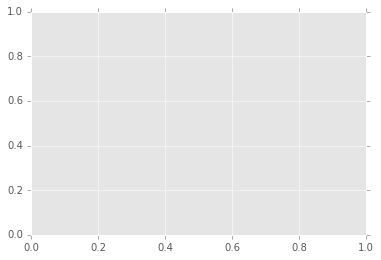

In [10]:
data.plot(column='n_Family

In [ ]:
from external_plugins.spystats.spystats import tools as tl

In [ ]:
vg = tl.Variogram(data,response_variable_name='n_Family')

In [ ]:
vg.plot(with_envelope=True)

## Let's bring some models

In [ ]:
m1 = tl.ExponentialVariogram(nugget=3.5,range_a=15,sill=6.5)
m2 = tl.GaussianVariogram(nugget=3.5,range_a=15,sill=6.5)
m4 = tl.SphericalVariogram(nugget=3.5,range_a=15,sill=6.5)

In [ ]:
vg.fitVariogramModel(m2)

In [ ]:
x = np.linspace(0,30,100)

vg.plot(with_envelope=False,n_bins=100)
plt.plot(x,vg.model.f(x))



In [ ]:
## We will retrieve environmental data from another region using the 'raster_api'
##We will do it like this:
cell = selection_of_cells.first()
## Go up 5 scales
upcell = cell.upperCell.next().upperCell.next().upperCell.next().upperCell.next().upperCell.next()
## Get the raster for this area, example Elevation
elev = upcell.getAssociatedRasterAreaData('Elevation')
## Get a dataframe
data_s = elev.toPandasDataFrame()
## Convert it to geoDataFrame
data_s = tl.toGeoDataFrame(data_s,xcoord_name='Longitude',ycoord_name='Latitude')
## Remove NAs
data_star = data_s.dropna()
## Restablish index to be continuous, this is important
#data_star.reset_index(drop=True,inplace=True)
## Plot it
data_star.plot(column=0)
##

# Bayesian Modelling


In [ ]:
import pymc3 as pm
data.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'geometry']

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('n_Family ~ Elevation_mean',data=data)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

In [ ]:
## cero coef for long lat
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

In [ ]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=data[['Longitude','Latitude','Elevation_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=data[['n_Family']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    %time f_star = gp.conditional("f_star", data_star.iloc[:,:3].values)
                    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


In [ ]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [ ]:
preds['mean_sample'] = preds.mean(axis=1)

In [ ]:
preds['idx'] = data_star.index.values

In [ ]:
test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [ ]:
test1

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=test1.iloc[:,0],s=200)
plt.colorbar()
#plt.scatter(data_star.Longitude,data_star.Latitude,c=data_star.pred,s=20,alpha=0.8)




In [ ]:
fig, ax = plt.subplots(figsize=(14, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=np.exp(test1.mean_sample.values),s=50,alpha=0.9)
plt.colorbar()
#plt.scatter(gdata.Longitude,gdata.Latitude,c='k',s=gdata.Nsp,alpha=0.5)

# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
 For achieving this I'll explore *rasterio* package (MapBox, 2016)

In [ ]:
import rasterio as rast

In [ ]:
from rasterio.features import rasterize,guard_transform

In [ ]:
import numpy as np

In [ ]:
shapes = ((geom,val) for geom, val in zip(test1.geometry,np.exp(test1.mean_sample.values)))

In [ ]:
len(shapes)

In [ ]:
shapes = list(shapes)


In [ ]:
elev.rasterdata.geotransform

In [ ]:
elev.rasterdata.bands[0].data().shape

In [ ]:
#rastband1 = elev.rasterdata.bands[0].data()

newr = rasterize(shapes,out_shape=(60,65),all_touched=False,fill=np.nan,transform=elev.rasterdata.geotransform)

In [ ]:
Z = test1.mean_sample.values.reshape(60,65)
Z1 = np.ma.masked_where(Z == np.nan,Z)

In [ ]:
plt.imshow(np.exp(Z1),cmap=plt.cm.Accent)
plt.colorbar()

In [ ]:
## With pcolormesh
x = np.linspace(0,100,65)
y = np.linspace(0,100,60)
XX,YY = np.meshgrid(x,y)
ZZ = np.exp(Z1)
z_min = np.nanmin(ZZ)
z_max = np.nanmax(ZZ)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,np.exp(Z1),cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar()

In [ ]:
b = elev.rasterdata.bands[0]

In [ ]:
values = b.data()

In [ ]:
from matplotlib import colors

In [ ]:
# colormap normalizer

fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,values,cmap=plt.cm.CMRmap_r,norm = colors.Normalize(vmin=0.0,vmax=1800))
plt.colorbar()